In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
from pickle import dump
import pickle, os
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

from Bio.Seq import Seq
from Bio import SeqIO

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [2]:
models = ['adhunter_PADI', 'adhunter_GCN4', 'PADDLE', 'ADpred', 'TADA', 'Sanjana']
model_metrics = ['roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
predictor_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5]

In [3]:
pl.seed_everything(0)

Global seed set to 0


0

## ARF Ortholog metrics

In [4]:
print('adhunter_PADI Predictor thresholds used to calculate accuracy and the F1-score:\n', predictor_thresholds)
print('adhunter_GCN4 Predictor thresholds used to calculate accuracy and the F1-score:\n', [80000, 90000, 100000])

adhunter_PADI Predictor thresholds used to calculate accuracy and the F1-score:
 [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5]
adhunter_GCN4 Predictor thresholds used to calculate accuracy and the F1-score:
 [80000, 90000, 100000]


In [5]:
activity_df = pd.read_csv('../ARFOrthologs/ARFEvo_scores.csv')
activity_df = activity_df.loc[activity_df.loc[:,['Fragment Sequence', 'ScaleScore']].drop_duplicates().index]
seqs = activity_df['Fragment Sequence']
activity = activity_df['ScaleScore']

"""
paddle_df = pd.read_csv('YOUR_DATASET_PADDLE.csv')
paddle_df = paddle_df[paddle_df.seq.isin(seqs)]
paddle_df = paddle_df.loc[paddle_df.loc[:, ['seq']].drop_duplicates().index]
# Sort df_sort by the order provided in seqs
paddle_df.seq = paddle_df.seq.astype("category")
paddle_df.seq = paddle_df.seq.cat.set_categories(seqs)
paddle_df = paddle_df.sort_values(by=['seq'])
paddle = np.vstack(paddle_df.PADDLE_pred.values).flatten()
assert len(activity)==len(paddle)

adpred_df = pd.read_csv('YOUR_DATASET_adpred.csv', converters={'position_wise_prob_adpred':pd.eval})
adpred_df = adpred_df[adpred_df.sequence.isin(seqs)]
adpred_df = adpred_df.loc[adpred_df.loc[:, ['sequence']].drop_duplicates().index]
adpred_df.sequence = adpred_df.sequence.astype("category")
adpred_df.sequence = adpred_df.sequence.cat.set_categories(seqs)
adpred_df = adpred_df.sort_values(by=['sequence'])
# Includes adpred's native padding of G's at the extremes
adpred = np.vstack(adpred_df.position_wise_prob_adpred.values).mean(axis=1).flatten()
# Since adpred uses tiles of 30, avg over 10 values to get adpred for the last 40 aa
adpred_last40 = np.vstack(adpred_df.position_wise_prob_adpred.values)[:,(15+(53-40)):53-15].mean(axis=1).flatten()
adpred_max = np.vstack(adpred_df.position_wise_prob_adpred.values).max(axis=1).flatten()
assert len(activity)==len(adpred)
"""
preds_df = pd.read_csv('../ARFOrthologs/hunter_PADI_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_PADI = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
assert len(activity)==len(adhunter_PADI)

preds_df = pd.read_csv('../ARFOrthologs/hunter_GCN4_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_GCN4 = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
assert len(activity)==len(adhunter_GCN4)
"""
preds_df = tada_all
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
tada = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
tada_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
tada_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
tada_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(tada)

preds_df = pd.read_csv('sanjana_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# Last40 and max are still binary, avg results in values between 0 and 1. Use threshold 0.5
sanjana = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
sanjana_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
sanjana_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
sanjana_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(sanjana)
"""

thresh = 1
exp_labels = np.where(activity > thresh, 1, 0)

In [6]:
pd.DataFrame({'sequences':seqs, 'activity':activity, 'PADDLE_ADpred_seqs':'SHLATAGSTSSAS' + seqs, 
              'ADHunter_PADI_preds':adhunter_PADI, 'ADHunter_GCN4_preds':adhunter_GCN4}).to_csv('model_metrics_df_ARF_Orthologs.csv', encoding='utf-8', index=False)
0

0

<Axes: xlabel='ScaleScore', ylabel='Count'>

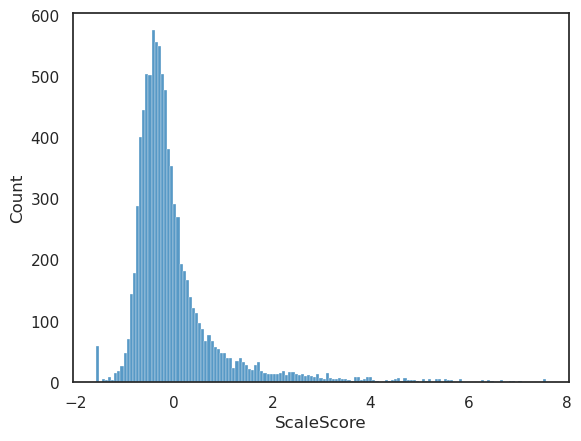

In [7]:
sns.histplot(activity)

In [8]:
model_name = 'adhunter_PADI'
y_true, y_pred = exp_labels, adhunter_PADI
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
metrics_df = pd.DataFrame(columns=add_values)
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in predictor_thresholds]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in predictor_thresholds]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [9]:
model_name = 'adhunter_GCN4'
y_true, y_pred = exp_labels, adhunter_GCN4
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in [80000, 90000, 100000]]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in [80000, 90000, 100000]]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [10]:
metrics_df

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,adhunter_PADI,0.832,0.468,"[0.898, 0.906, 0.909, 0.911, 0.912, 0.913, 0.9...","[0.49, 0.486, 0.466, 0.436, 0.417, 0.393, 0.35...","[0.4983089064261556, 0.45208568207440814, 0.40...","[0.05790182396866202, 0.04382421349002326, 0.0...","[0.48148148148148145, 0.524869109947644, 0.548...","[0.4983089064261556, 0.45208568207440814, 0.40..."
1,adhunter_GCN4,0.777,0.373,"[0.898, 0.906, 0.908]","[0.406, 0.358, 0.301]","[0.35625704622322435, 0.26832018038331457, 0.2...","[0.043089729465050804, 0.02509487085322561, 0....","[0.47305389221556887, 0.5348314606741573, 0.58...","[0.35625704622322435, 0.26832018038331457, 0.2..."


#### Is PADI better for training than the GCN4 Orthologs for this dataset?

In [11]:
selected = metrics_df[metrics_df.model.isin(['adhunter_GCN4', 'adhunter_PADI'])].copy()
display(selected)
        
selected.accuracy = [selected[selected.model=='adhunter_PADI'].accuracy.iloc[0][6],
                     selected[selected.model=='adhunter_GCN4'].accuracy.iloc[0][-1]]
selected.f1 = [selected[selected.model=='adhunter_PADI'].f1.iloc[0][6],
               selected[selected.model=='adhunter_GCN4'].f1.iloc[0][-1]]
selected = selected.loc[:, ['roc_auc', 'pr_auc', 'accuracy', 'f1']].transpose()
selected.columns = ['adhunter_PADI', 'adhunter_GCN4']
selected

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,adhunter_PADI,0.832,0.468,"[0.898, 0.906, 0.909, 0.911, 0.912, 0.913, 0.9...","[0.49, 0.486, 0.466, 0.436, 0.417, 0.393, 0.35...","[0.4983089064261556, 0.45208568207440814, 0.40...","[0.05790182396866202, 0.04382421349002326, 0.0...","[0.48148148148148145, 0.524869109947644, 0.548...","[0.4983089064261556, 0.45208568207440814, 0.40..."
1,adhunter_GCN4,0.777,0.373,"[0.898, 0.906, 0.908]","[0.406, 0.358, 0.301]","[0.35625704622322435, 0.26832018038331457, 0.2...","[0.043089729465050804, 0.02509487085322561, 0....","[0.47305389221556887, 0.5348314606741573, 0.58...","[0.35625704622322435, 0.26832018038331457, 0.2..."


,adhunter_PADI,adhunter_GCN4
roc_auc,0.832,0.777
pr_auc,0.468,0.373
accuracy,0.912,0.908
f1,0.359,0.301


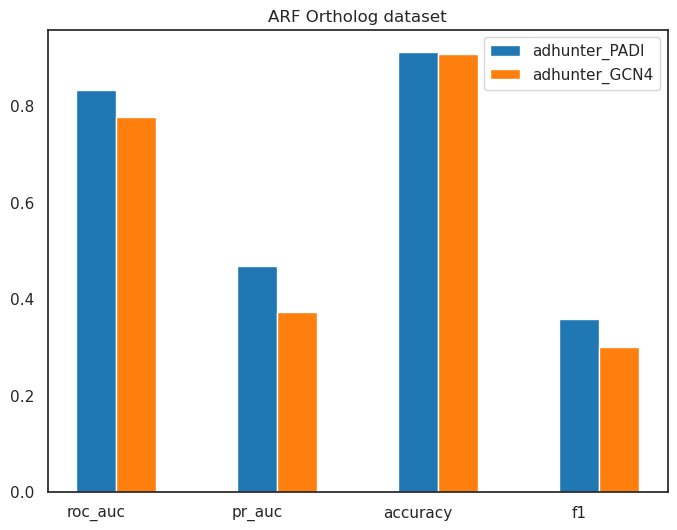

In [12]:
pdf = matplotlib.backends.backend_pdf.PdfPages("figures/PADIvGCN4_metrics.pdf")
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(4), selected.adhunter_PADI, width=.25, label='adhunter_PADI')
ax.bar(np.arange(4)+.25, selected.adhunter_GCN4, width=.25, label='adhunter_GCN4')
ax.set_xticks(np.arange(4), selected.index.tolist())
ax.legend()
ax.set(title='ARF Ortholog dataset')
pdf.savefig(dpi=300)
#pdf.close()
plt.show()
#sns.set_context('poster')

## PADI

In [13]:
activity_df = pd.read_csv('../PADI/PADI.csv')
activity_df = activity_df.loc[activity_df.loc[:,['ADseq', 'PADI Score']].drop_duplicates().index]
activity_df = activity_df[~np.isnan(activity_df['PADI Score'])]
seqs = activity_df['ADseq']
activity = activity_df['PADI Score']

paddle_df = pd.read_csv('../PADI/PADI_53/PADI_PADDLE_ADpred_53_preds.csv', converters={'paddle_preds':pd.eval, 'adpred_preds':pd.eval}).rename(columns={'sequence':'seq'})
paddle_df = paddle_df[paddle_df.seq.isin('SHLATAGSTSSAS' + seqs)]
paddle_df = paddle_df.loc[paddle_df.loc[:, ['seq']].drop_duplicates().index]
# Sort df_sort by the order provided in seqs
paddle_df.seq = paddle_df.seq.astype("category")
paddle_df.seq = paddle_df.seq.cat.set_categories('SHLATAGSTSSAS' + seqs)
paddle_df = paddle_df.sort_values(by=['seq'])
paddle = np.vstack(paddle_df.paddle_preds.values).flatten()
assert len(activity)==len(paddle)

adpred_df = paddle_df
# Includes adpred's native padding of G's at the extremes (or GGSHLATAGSTSSAS at the N-terminus)
adpred = np.vstack(adpred_df.adpred_preds.values)[:,(53-40):].mean(axis=1).flatten()
# Since adpred uses tiles of 30, avg over 10 values to get adpred for the last 40 aa
adpred_last40 = np.vstack(adpred_df.adpred_preds.values)[:,(15+(53-40)):53-15].mean(axis=1).flatten()
#adpred_max = np.vstack(adpred_df.position_wise_prob_adpred.values).max(axis=1).flatten()
assert len(activity)==len(adpred)

preds_df = pd.read_csv('../PADI/hunter_PADI_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_PADI = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
adhunter_PADI_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
adhunter_PADI_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
adhunter_PADI_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(adhunter_PADI)

preds_df = pd.read_csv('../PADI/hunter_GCN4_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_GCN4 = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
adhunter_GCN4_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
adhunter_GCN4_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
adhunter_GCN4_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(adhunter_GCN4)

preds_df = pd.read_csv('../PADI/new_TADA/TADA_Predictions.csv')
preds_df = preds_df[preds_df.sequences.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['sequences']].drop_duplicates().index]
preds_df.sequences = preds_df.sequences.astype("category")
preds_df.sequences = preds_df.sequences.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['sequences'])
# No padding, just all 40-mers in 53aa sequence
tada = np.vstack(preds_df.predictions.values).mean(axis=1).flatten()
#tada_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
#tada_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
#tada_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(tada)

preds_df = pd.read_csv('../PADI/Sanjana_preds.csv', converters={'predictions':pd.eval})
preds_df = preds_df[preds_df.sequences.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['sequences']].drop_duplicates().index]
preds_df.sequences = preds_df.sequences.astype("category")
preds_df.sequences = preds_df.sequences.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['sequences'])
# Last40 and max are still binary, avg results in values between 0 and 1. Use threshold 0.5
sanjana = np.vstack(preds_df.predictions.values).mean(axis=1).flatten()
#sanjana_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
#sanjana_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
#sanjana_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(sanjana)

thresh = 1
exp_labels = np.where(activity > thresh, 1, 0)

In [14]:
pd.DataFrame({'sequences':seqs, 'activity':activity, 'PADDLE_ADpred_seqs':'SHLATAGSTSSAS' + seqs, 
              'PADDLE_preds':paddle, 'ADpred_preds':adpred, 'ADHunter_PADI_preds':adhunter_PADI, 'ADHunter_GCN4_preds':adhunter_GCN4, 
              'TADA_preds':tada, 'Sanjana_preds':sanjana}).to_csv('model_metrics_df_PADI.csv', encoding='utf-8', index=False)
0

0

In [15]:
model_name = 'PADDLE'
y_true, y_pred = exp_labels, paddle
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
metrics_df = pd.DataFrame(columns=add_values)
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > 4, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > 4, 1, 0)), 3)

t = 4
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [16]:
model_name = 'ADpred'
y_true, y_pred = exp_labels, adpred
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > 0.8, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > 0.8, 1, 0)), 3)

t = 0.8
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [17]:
model_name = 'adhunter_PADI'
y_true, y_pred = exp_labels, adhunter_PADI
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in predictor_thresholds]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in predictor_thresholds]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [18]:
model_name = 'adhunter_GCN4'
y_true, y_pred = exp_labels, adhunter_GCN4
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in [80000, 90000, 100000]]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in [80000, 90000, 100000]]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [19]:
model_name = 'TADA'
y_true, y_pred = exp_labels, tada
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in predictor_thresholds]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in predictor_thresholds]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [20]:
model_name = 'Sanjana'
y_true, y_pred = exp_labels, sanjana
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

t = 0.5
# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [21]:
metrics_df

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.861,0.538,0.928,0.451,0.327631,0.012399,0.724483,0.327631
1,ADpred,0.864,0.504,0.91,0.024,0.012105,0.000273,0.815217,0.012105
2,adhunter_PADI,0.898,0.686,"[0.911, 0.92, 0.927, 0.932, 0.936, 0.938, 0.94...","[0.603, 0.622, 0.636, 0.646, 0.651, 0.651, 0.6...","[0.7441897998708844, 0.7253066494512589, 0.703...","[0.07208249012238604, 0.06029359802126498, 0.0...","[0.506814684546054, 0.5449254274281556, 0.5793...","[0.7441897998708844, 0.7253066494512589, 0.703..."
3,adhunter_GCN4,0.811,0.461,"[0.905, 0.915, 0.92]","[0.483, 0.475, 0.452]","[0.4930600387346675, 0.42479018721755973, 0.36...","[0.054415213131605154, 0.03637852944010793, 0....","[0.47393732547316164, 0.5373621886484279, 0.59...","[0.4930600387346675, 0.42479018721755973, 0.36..."
4,TADA,0.890,0.601,"[0.92, 0.933, 0.922, 0.91, 0.909, 0.909, 0.909...","[0.593, 0.538, 0.297, 0.016, 0.0, 0.0, 0.0, 0....","[0.6404131697869593, 0.4281794706262105, 0.181...","[0.05174906042208731, 0.016430567601426232, 0....","[0.5522616562282533, 0.7219047619047619, 0.829...","[0.6404131697869593, 0.4281794706262105, 0.180..."
5,Sanjana,0.561,0.451,0.916,0.214,0.126533,0.005477,0.090508,1.0


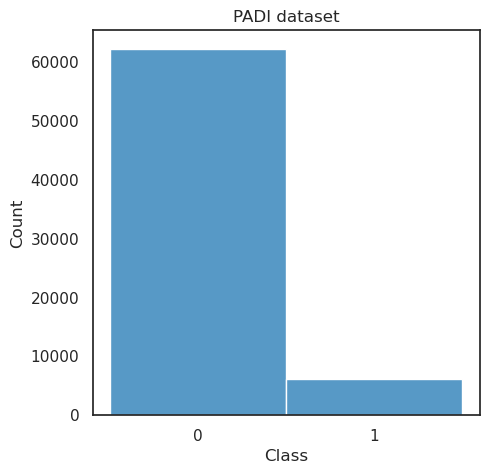

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(exp_labels, discrete=True, ax=ax)
ax.set_xticks([0, 1])
ax.set(xlabel='Class')
ax.set(title='PADI dataset')
pdf.savefig(dpi=300)
plt.show()

In [23]:
selected = metrics_df.copy()
display(selected)
selected = selected.loc[:, ['roc_auc', 'pr_auc']].transpose()
selected.columns = metrics_df.model.values
selected

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.861,0.538,0.928,0.451,0.327631,0.012399,0.724483,0.327631
1,ADpred,0.864,0.504,0.91,0.024,0.012105,0.000273,0.815217,0.012105
2,adhunter_PADI,0.898,0.686,"[0.911, 0.92, 0.927, 0.932, 0.936, 0.938, 0.94...","[0.603, 0.622, 0.636, 0.646, 0.651, 0.651, 0.6...","[0.7441897998708844, 0.7253066494512589, 0.703...","[0.07208249012238604, 0.06029359802126498, 0.0...","[0.506814684546054, 0.5449254274281556, 0.5793...","[0.7441897998708844, 0.7253066494512589, 0.703..."
3,adhunter_GCN4,0.811,0.461,"[0.905, 0.915, 0.92]","[0.483, 0.475, 0.452]","[0.4930600387346675, 0.42479018721755973, 0.36...","[0.054415213131605154, 0.03637852944010793, 0....","[0.47393732547316164, 0.5373621886484279, 0.59...","[0.4930600387346675, 0.42479018721755973, 0.36..."
4,TADA,0.890,0.601,"[0.92, 0.933, 0.922, 0.91, 0.909, 0.909, 0.909...","[0.593, 0.538, 0.297, 0.016, 0.0, 0.0, 0.0, 0....","[0.6404131697869593, 0.4281794706262105, 0.181...","[0.05174906042208731, 0.016430567601426232, 0....","[0.5522616562282533, 0.7219047619047619, 0.829...","[0.6404131697869593, 0.4281794706262105, 0.180..."
5,Sanjana,0.561,0.451,0.916,0.214,0.126533,0.005477,0.090508,1.0


,PADDLE,ADpred,adhunter_PADI,adhunter_GCN4,TADA,Sanjana
roc_auc,0.861,0.864,0.898,0.811,0.890,0.561
pr_auc,0.538,0.504,0.686,0.461,0.601,0.451


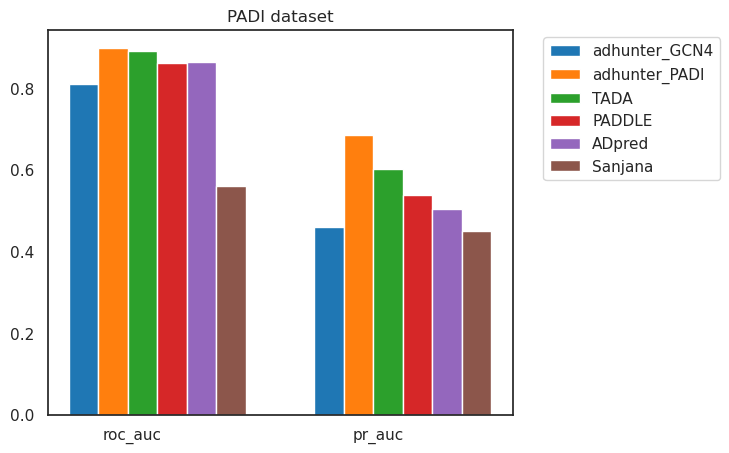

In [24]:
fig, ax = plt.subplots(figsize=(6,5))
i = 0
for m in ['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana']:
    ax.bar(np.arange(2)+(.12*i), selected[m], width=.12, label=m)
    i += 1
ax.set_xticks(np.arange(2)+.2, selected.index.tolist())
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set(title='PADI dataset')
pdf.savefig(bbox_inches='tight',dpi=300)
plt.show()
#sns.set_context('poster')

In [25]:
selected = metrics_df[metrics_df.model.isin(['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana'])].copy()
selected_models = selected.model.values
display(selected)
met = {key:[] for key in ['accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']}
for key, val in met.items():
    for i in range(len(selected)):
        if selected.model.iloc[i] == 'adhunter_PADI':
            val.append(selected[key].iloc[i][6])
        elif selected.model.iloc[i] == 'TADA':
            val.append(selected[key].iloc[i][1])
        elif selected.model.iloc[i] == 'adhunter_GCN4':
            val.append(selected[key].iloc[i][-1])
        else:
            val.append(selected[key].iloc[i])
    selected[key] = val
selected = selected.loc[:, ['accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']].transpose()
selected.columns = selected_models
selected

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.861,0.538,0.928,0.451,0.327631,0.012399,0.724483,0.327631
1,ADpred,0.864,0.504,0.91,0.024,0.012105,0.000273,0.815217,0.012105
2,adhunter_PADI,0.898,0.686,"[0.911, 0.92, 0.927, 0.932, 0.936, 0.938, 0.94...","[0.603, 0.622, 0.636, 0.646, 0.651, 0.651, 0.6...","[0.7441897998708844, 0.7253066494512589, 0.703...","[0.07208249012238604, 0.06029359802126498, 0.0...","[0.506814684546054, 0.5449254274281556, 0.5793...","[0.7441897998708844, 0.7253066494512589, 0.703..."
3,adhunter_GCN4,0.811,0.461,"[0.905, 0.915, 0.92]","[0.483, 0.475, 0.452]","[0.4930600387346675, 0.42479018721755973, 0.36...","[0.054415213131605154, 0.03637852944010793, 0....","[0.47393732547316164, 0.5373621886484279, 0.59...","[0.4930600387346675, 0.42479018721755973, 0.36..."
4,TADA,0.890,0.601,"[0.92, 0.933, 0.922, 0.91, 0.909, 0.909, 0.909...","[0.593, 0.538, 0.297, 0.016, 0.0, 0.0, 0.0, 0....","[0.6404131697869593, 0.4281794706262105, 0.181...","[0.05174906042208731, 0.016430567601426232, 0....","[0.5522616562282533, 0.7219047619047619, 0.829...","[0.6404131697869593, 0.4281794706262105, 0.180..."
5,Sanjana,0.561,0.451,0.916,0.214,0.126533,0.005477,0.090508,1.0


,PADDLE,ADpred,adhunter_PADI,adhunter_GCN4,TADA,Sanjana
accuracy,0.928000,0.910000,0.940000,0.920000,0.933000,0.916000
f1,0.451000,0.024000,0.649000,0.452000,0.538000,0.214000
tpr,0.327631,0.012105,0.615397,0.365236,0.428179,0.126533
fpr,0.012399,0.000273,0.028027,0.024911,0.016431,0.005477
precision,0.724483,0.815217,0.686038,0.592874,0.721905,0.090508
recall,0.327631,0.012105,0.615397,0.365236,0.428179,1.000000


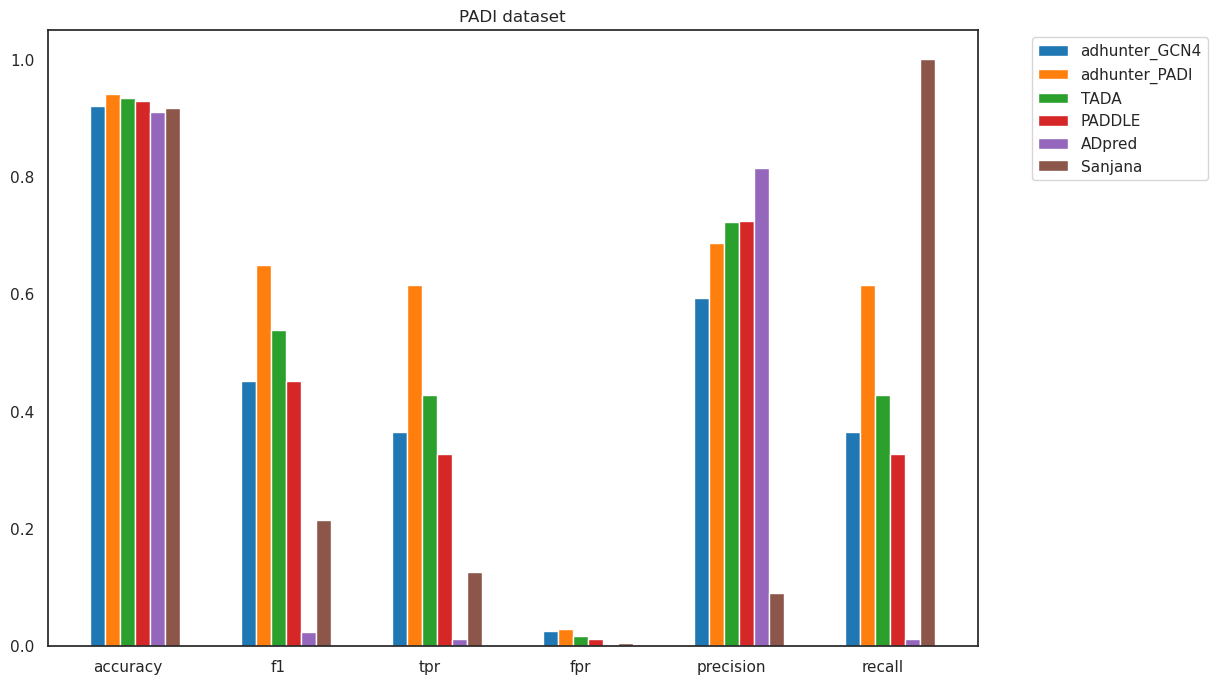

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
i = 0
for m in ['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana']:
    ax.bar(np.arange(6)+(.1*i), selected[m], width=.1, label=m)
    i += 1
ax.set_xticks(np.arange(6)+.2, selected.index.tolist())
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set(title='PADI dataset')
pdf.savefig(bbox_inches='tight',dpi=300)
plt.show()
#sns.set_context('poster')

## GCN4 Orthologs

In [27]:
activity_df = pd.read_csv('../GCN4_Orthologs/OrthologTilingDFwActivities_20230414.csv')
activity_df = activity_df.loc[activity_df.loc[:,['Seq', 'Activity']].drop_duplicates().index]
activity_df = activity_df[(activity_df.Activity != 0.0) & (~np.isnan(activity_df.Activity))]
seqs = activity_df['Seq']
activity = activity_df['Activity']

paddle_df = pd.read_csv('../GCN4_Orthologs/GCN4_Orthologs_53/GCN4_Orthologs_PADDLE_ADpred_53_preds.csv', converters={'paddle_preds':pd.eval, 'adpred_preds':pd.eval}).rename(columns={'sequence':'seq'})
paddle_df = paddle_df[paddle_df.seq.isin('SHLATAGSTSSAS' + seqs)]
paddle_df = paddle_df.loc[paddle_df.loc[:, ['seq']].drop_duplicates().index]
# Sort df_sort by the order provided in seqs
paddle_df.seq = paddle_df.seq.astype("category")
paddle_df.seq = paddle_df.seq.cat.set_categories('SHLATAGSTSSAS' + seqs)
paddle_df = paddle_df.sort_values(by=['seq'])
paddle = np.vstack(paddle_df.paddle_preds.values).flatten()
assert len(activity)==len(paddle)

adpred_df = paddle_df
# Includes adpred's native padding of G's at the extremes (or GGSHLATAGSTSSAS at the N-terminus)
adpred = np.vstack(adpred_df.adpred_preds.values)[:,(53-40):].mean(axis=1).flatten()
# Since adpred uses tiles of 30, avg over 10 values to get adpred for the last 40 aa
adpred_last40 = np.vstack(adpred_df.adpred_preds.values)[:,(15+(53-40)):53-15].mean(axis=1).flatten()
#adpred_max = np.vstack(adpred_df.position_wise_prob_adpred.values).max(axis=1).flatten()
assert len(activity)==len(adpred)

preds_df = pd.read_csv('../GCN4_Orthologs/hunter_PADI_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_PADI = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
adhunter_PADI_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
adhunter_PADI_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
adhunter_PADI_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(adhunter_PADI)

preds_df = pd.read_csv('../GCN4_Orthologs/hunter_GCN4_all40.csv', converters={'Predicted':pd.eval})
preds_df = preds_df[preds_df.Seq.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['Seq']].drop_duplicates().index]
preds_df.Seq = preds_df.Seq.astype("category")
preds_df.Seq = preds_df.Seq.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['Seq'])
# No padding, just all 40-mers in 53aa sequence
adhunter_GCN4 = np.vstack(preds_df.Predicted.values).mean(axis=1).flatten()
adhunter_GCN4_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
adhunter_GCN4_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
adhunter_GCN4_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(adhunter_GCN4)

preds_df = pd.read_csv('../GCN4_Orthologs/new_TADA/TADA_Predictions.csv')
preds_df = preds_df[preds_df.sequences.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['sequences']].drop_duplicates().index]
preds_df.sequences = preds_df.sequences.astype("category")
preds_df.sequences = preds_df.sequences.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['sequences'])
# No padding, just all 40-mers in 53aa sequence
tada = np.vstack(preds_df.predictions.values).mean(axis=1).flatten()
#tada_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
#tada_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
#tada_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(tada)

preds_df = pd.read_csv('../GCN4_Orthologs/Sanjana_preds.csv', converters={'predictions':pd.eval})
preds_df = preds_df[preds_df.sequences.isin(seqs)]
preds_df = preds_df.loc[preds_df.loc[:, ['sequences']].drop_duplicates().index]
preds_df.sequences = preds_df.sequences.astype("category")
preds_df.sequences = preds_df.sequences.cat.set_categories(seqs)
preds_df = preds_df.sort_values(by=['sequences'])
# Last40 and max are still binary, avg results in values between 0 and 1. Use threshold 0.5
sanjana = np.vstack(preds_df.predictions.values).mean(axis=1).flatten()
#sanjana_last40 = np.vstack(preds_df.Predicted.values)[:,-1].flatten()
#sanjana_first40 = np.vstack(preds_df.Predicted.values)[:,0].flatten()
#sanjana_max = np.vstack(preds_df.Predicted.values).max(axis=1).flatten()
assert len(activity)==len(sanjana)

thresh = 100000
exp_labels = np.where(activity > thresh, 1, 0)

In [28]:
pd.DataFrame({'sequences':seqs, 'activity':activity, 'PADDLE_ADpred_seqs':'SHLATAGSTSSAS' + seqs, 
              'PADDLE_preds':paddle, 'ADpred_preds':adpred, 'ADHunter_PADI_preds':adhunter_PADI, 'ADHunter_GCN4_preds':adhunter_GCN4, 
              'TADA_preds':tada, 'Sanjana_preds':sanjana}).to_csv('model_metrics_df_GCN4_Orthologs.csv', encoding='utf-8', index=False)
0

0

In [29]:
model_name = 'PADDLE'
y_true, y_pred = exp_labels, paddle
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
metrics_df = pd.DataFrame(columns=add_values)
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > 4, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > 4, 1, 0)), 3)

t = 4
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [30]:
model_name = 'ADpred'
y_true, y_pred = exp_labels, adpred
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > 0.8, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > 0.8, 1, 0)), 3)

t = 0.8
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [31]:
model_name = 'adhunter_PADI'
y_true, y_pred = exp_labels, adhunter_PADI
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in predictor_thresholds]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in predictor_thresholds]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [32]:
model_name = 'adhunter_GCN4'
y_true, y_pred = exp_labels, adhunter_GCN4
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in [80000, 90000, 100000]]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in [80000, 90000, 100000]]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in [80000, 90000, 100000]]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [33]:
model_name = 'TADA'
y_true, y_pred = exp_labels, tada
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = [round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                        for t in predictor_thresholds]
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = [round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3) 
                                  for t in predictor_thresholds]

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[6] = fpr[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()
add_values[8] = recall[[np.abs(t - thresholds).argmin() for t in predictor_thresholds]].tolist()

metrics_df.loc[len(metrics_df.index)] = add_values

In [34]:
model_name = 'Sanjana'
y_true, y_pred = exp_labels, sanjana
add_values = ['model', 'roc_auc', 'pr_auc', 'accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']
add_values[0] = model_name

t = 0.5
# Saving the AUC for ROC and Precision-Recall curves
add_values[1] = round(roc_auc_score(y_true, y_pred), 3)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[2] = round(auc(recall, precision), 3)
# Saving the accuracy and F1 score
add_values[3] = round( accuracy_score(y_true, np.where(y_pred > t, 1, 0)), 3)
# Only the F1 score for the positive class (ADs) is saved
add_values[4] = round( f1_score(y_true, np.where(y_pred > t, 1, 0)), 3)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
add_values[5] = tpr[np.abs(t - thresholds).argmin()]
add_values[6] = fpr[np.abs(t - thresholds).argmin()]
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
add_values[7] = precision[np.abs(t - thresholds).argmin()]
add_values[8] = recall[np.abs(t - thresholds).argmin()]

metrics_df.loc[len(metrics_df.index)] = add_values

In [35]:
metrics_df

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.930,0.776,0.886,0.678,0.653989,0.061861,0.703909,0.653989
1,ADpred,0.924,0.754,0.816,0.001,0.000286,0.0,1.0,0.000572
2,adhunter_PADI,0.931,0.763,"[0.855, 0.861, 0.868, 0.873, 0.877, 0.88, 0.88...","[0.684, 0.689, 0.694, 0.695, 0.694, 0.692, 0.6...","[0.8575922219044896, 0.8370031455533314, 0.813...","[0.14616423381133045, 0.1332390199987139, 0.11...","[0.5689622462530829, 0.5858686949559647, 0.605...","[0.8575922219044896, 0.8370031455533314, 0.813..."
3,adhunter_GCN4,0.979,0.926,"[0.933, 0.945, 0.948]","[0.836, 0.854, 0.853]","[0.9259365170145839, 0.8801830140120103, 0.828...","[0.06488328724840846, 0.04057616873512957, 0.0...","[0.7624205321403343, 0.8299191374663073, 0.879...","[0.9259365170145839, 0.8804689734057763, 0.828..."
4,TADA,0.935,0.788,"[0.865, 0.895, 0.87, 0.817, 0.816, 0.816, 0.81...","[0.693, 0.695, 0.473, 0.003, 0.0, 0.0, 0.0, 0....","[0.8324277952530741, 0.6499857020303117, 0.318...","[0.1282232653848627, 0.04957880522152916, 0.00...","[0.5934760448521916, 0.7467148488830486, 0.920...","[0.8324277952530741, 0.6499857020303117, 0.318..."
5,Sanjana,0.591,0.550,0.841,0.312,0.196168,0.014147,0.183589,1.0


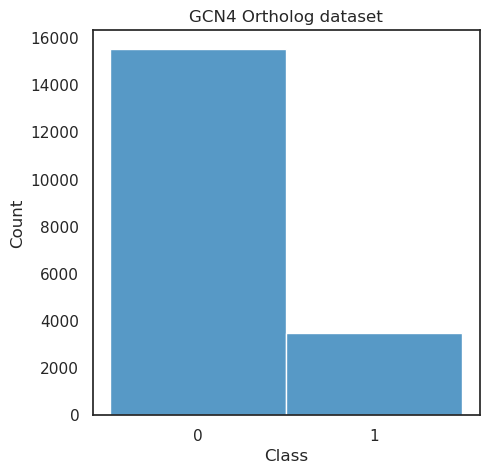

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(exp_labels, discrete=True, ax=ax)
ax.set_xticks([0, 1])
ax.set(xlabel='Class')
ax.set(title='GCN4 Ortholog dataset')
pdf.savefig(dpi=300)
plt.show()

In [37]:
selected = metrics_df.copy()
display(selected)
selected = selected.loc[:, ['roc_auc', 'pr_auc']].transpose()
selected.columns = metrics_df.model.values
selected

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.930,0.776,0.886,0.678,0.653989,0.061861,0.703909,0.653989
1,ADpred,0.924,0.754,0.816,0.001,0.000286,0.0,1.0,0.000572
2,adhunter_PADI,0.931,0.763,"[0.855, 0.861, 0.868, 0.873, 0.877, 0.88, 0.88...","[0.684, 0.689, 0.694, 0.695, 0.694, 0.692, 0.6...","[0.8575922219044896, 0.8370031455533314, 0.813...","[0.14616423381133045, 0.1332390199987139, 0.11...","[0.5689622462530829, 0.5858686949559647, 0.605...","[0.8575922219044896, 0.8370031455533314, 0.813..."
3,adhunter_GCN4,0.979,0.926,"[0.933, 0.945, 0.948]","[0.836, 0.854, 0.853]","[0.9259365170145839, 0.8801830140120103, 0.828...","[0.06488328724840846, 0.04057616873512957, 0.0...","[0.7624205321403343, 0.8299191374663073, 0.879...","[0.9259365170145839, 0.8804689734057763, 0.828..."
4,TADA,0.935,0.788,"[0.865, 0.895, 0.87, 0.817, 0.816, 0.816, 0.81...","[0.693, 0.695, 0.473, 0.003, 0.0, 0.0, 0.0, 0....","[0.8324277952530741, 0.6499857020303117, 0.318...","[0.1282232653848627, 0.04957880522152916, 0.00...","[0.5934760448521916, 0.7467148488830486, 0.920...","[0.8324277952530741, 0.6499857020303117, 0.318..."
5,Sanjana,0.591,0.550,0.841,0.312,0.196168,0.014147,0.183589,1.0


,PADDLE,ADpred,adhunter_PADI,adhunter_GCN4,TADA,Sanjana
roc_auc,0.930,0.924,0.931,0.979,0.935,0.591
pr_auc,0.776,0.754,0.763,0.926,0.788,0.550


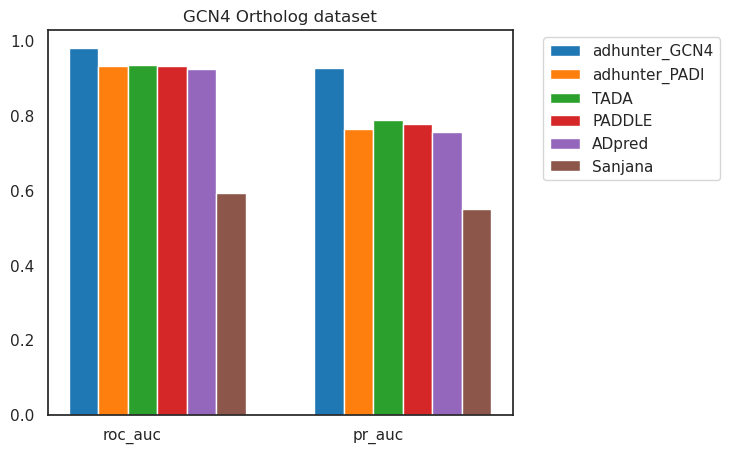

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
i = 0
for m in ['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana']:
    ax.bar(np.arange(2)+(.12*i), selected[m], width=.12, label=m)
    i += 1
ax.set_xticks(np.arange(2)+.2, selected.index.tolist())
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set(title='GCN4 Ortholog dataset')
pdf.savefig(bbox_inches='tight',dpi=300)
plt.show()
#sns.set_context('poster')

In [39]:
selected = metrics_df[metrics_df.model.isin(['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana'])].copy()
selected_models = selected.model.values
display(selected)
met = {key:[] for key in ['accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']}
for key, val in met.items():
    for i in range(len(selected)):
        if selected.model.iloc[i] == 'adhunter_PADI':
            val.append(selected[key].iloc[i][6])
        elif selected.model.iloc[i] == 'TADA':
            val.append(selected[key].iloc[i][1])
        elif selected.model.iloc[i] == 'adhunter_GCN4':
            val.append(selected[key].iloc[i][-1])
        else:
            val.append(selected[key].iloc[i])
    selected[key] = val
selected = selected.loc[:, ['accuracy', 'f1', 'tpr', 'fpr', 'precision', 'recall']].transpose()
selected.columns = selected_models
selected

,model,roc_auc,pr_auc,accuracy,f1,tpr,fpr,precision,recall
0,PADDLE,0.930,0.776,0.886,0.678,0.653989,0.061861,0.703909,0.653989
1,ADpred,0.924,0.754,0.816,0.001,0.000286,0.0,1.0,0.000572
2,adhunter_PADI,0.931,0.763,"[0.855, 0.861, 0.868, 0.873, 0.877, 0.88, 0.88...","[0.684, 0.689, 0.694, 0.695, 0.694, 0.692, 0.6...","[0.8575922219044896, 0.8370031455533314, 0.813...","[0.14616423381133045, 0.1332390199987139, 0.11...","[0.5689622462530829, 0.5858686949559647, 0.605...","[0.8575922219044896, 0.8370031455533314, 0.813..."
3,adhunter_GCN4,0.979,0.926,"[0.933, 0.945, 0.948]","[0.836, 0.854, 0.853]","[0.9259365170145839, 0.8801830140120103, 0.828...","[0.06488328724840846, 0.04057616873512957, 0.0...","[0.7624205321403343, 0.8299191374663073, 0.879...","[0.9259365170145839, 0.8804689734057763, 0.828..."
4,TADA,0.935,0.788,"[0.865, 0.895, 0.87, 0.817, 0.816, 0.816, 0.81...","[0.693, 0.695, 0.473, 0.003, 0.0, 0.0, 0.0, 0....","[0.8324277952530741, 0.6499857020303117, 0.318...","[0.1282232653848627, 0.04957880522152916, 0.00...","[0.5934760448521916, 0.7467148488830486, 0.920...","[0.8324277952530741, 0.6499857020303117, 0.318..."
5,Sanjana,0.591,0.550,0.841,0.312,0.196168,0.014147,0.183589,1.0


,PADDLE,ADpred,adhunter_PADI,adhunter_GCN4,TADA,Sanjana
accuracy,0.886000,0.816000,0.883000,0.948000,0.895000,0.841000
f1,0.678000,0.001000,0.691000,0.853000,0.695000,0.312000
tpr,0.653989,0.000286,0.710037,0.828424,0.649986,0.196168
fpr,0.061861,0.000000,0.077744,0.025465,0.049579,0.014147
precision,0.703909,1.000000,0.672446,0.879745,0.746715,0.183589
recall,0.653989,0.000572,0.709751,0.828424,0.649986,1.000000


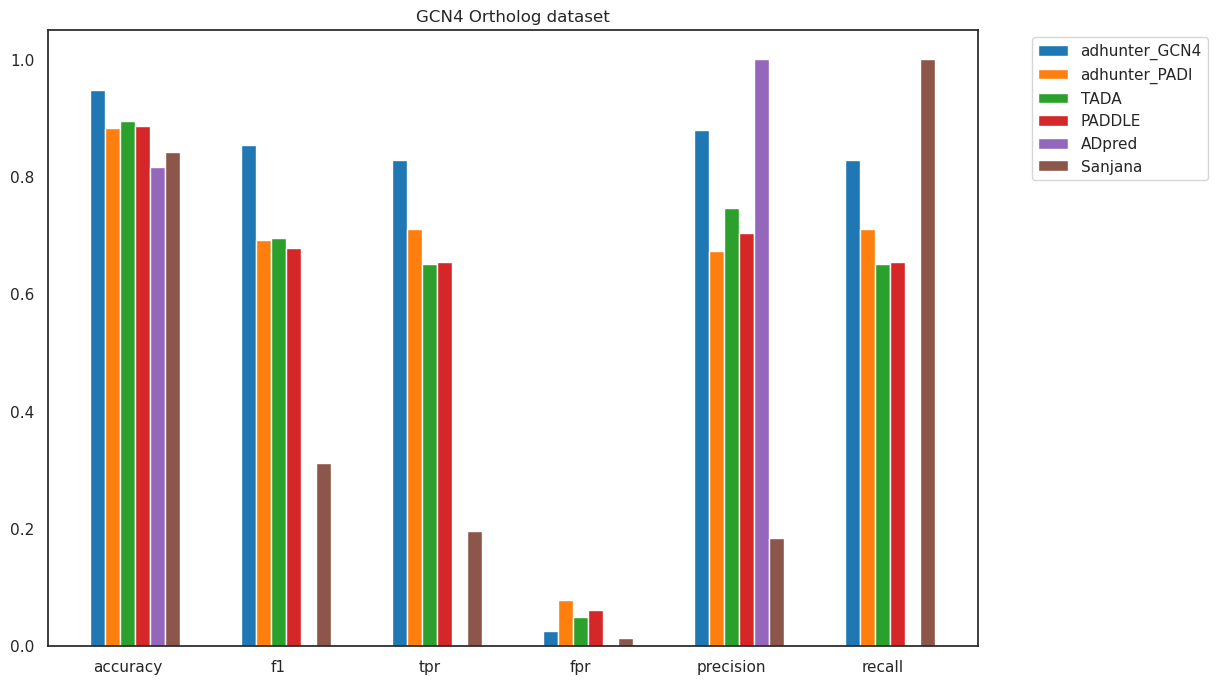

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
i = 0
for m in ['adhunter_GCN4', 'adhunter_PADI', 'TADA', 'PADDLE', 'ADpred', 'Sanjana']:
    ax.bar(np.arange(6)+(.1*i), selected[m], width=.1, label=m)
    i += 1
ax.set_xticks(np.arange(6)+.2, selected.index.tolist())
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set(title='GCN4 Ortholog dataset')
pdf.savefig(bbox_inches='tight',dpi=300)
plt.show()
#sns.set_context('poster')

In [41]:
pdf.close()